In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

%load_ext autoreload
%autoreload 2

In [3]:
path = '/Users/shikha/Documents/projects/kaggle/google_qa/'
train_file = path + "google_qa_train.csv"
test_file = path + "google_qa_test.csv"

df = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

In [4]:
feat_cols = [
    'question_title', 
    'question_body', 
    'question_user_name', 
    'question_user_page', 
    'answer', 
    'answer_user_name', 
    'answer_user_page', 
    'url', 
    'category', 
    'host']
target_cols = [
    'question_asker_intent_understanding', 
    'question_body_critical', 
    'question_conversational', 
    'question_expect_short_answer', 
    'question_fact_seeking', 
    'question_has_commonly_accepted_answer',
    'question_interestingness_others', 
    'question_interestingness_self', 
    'question_multi_intent', 
    'question_not_really_a_question', 
    'question_opinion_seeking', 
    'question_type_choice',
    'question_type_compare', 
    'question_type_consequence', 
    'question_type_definition', 
    'question_type_entity', 
    'question_type_instructions', 
    'question_type_procedure', 
    'question_type_reason_explanation', 
    'question_type_spelling',
    'question_well_written', 
    'answer_helpful', 
    'answer_level_of_information', 
    'answer_plausible', 
    'answer_relevance', 
    'answer_satisfaction', 
    'answer_type_instructions', 
    'answer_type_procedure', 
    'answer_type_reason_explanation',
    'answer_well_written'
]
print('we have %d feature columns and %d target columns' % (len(feat_cols) , len(target_cols)))

we have 10 feature columns and 30 target columns


In [5]:
# df['question_title_len'] = df['question_title'].map(lambda x: len(word_tokenize(x.decode('utf-8'))))
# df['question_body_len'] = df['question_body'].map(lambda x: len(word_tokenize(x.decode('utf-8'))))
# df['answer_len'] = df['answer'].map(lambda x: len(word_tokenize(x.decode('utf-8'))))

In [5]:
X_train = df.filter(feat_cols, axis=1)
Y_train = df[target_cols]
X_test = df_test.filter(feat_cols, axis=1)

In [6]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

class TextLengthFeature(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        new_feature = x.map(lambda a: len(word_tokenize(a)))
        new_feature_r = np.reshape(new_feature.values, (new_feature.size, 1))
        return new_feature_r

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD

numerical_attribute = list(X_train[['question_title', 'question_body', 'answer']])
categorical_attribute = list(X_train[['category', 'host']])
tfidf = TfidfVectorizer(min_df=1, strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words = 'english')

# Onehotencoding is performed for transforming categorical values as numerical
categorical_transformer = Pipeline([
    ('one_hot_encoder', OneHotEncoder())
])

# FeatureUnion: to concatenate features from both the transformer
# Pipeline: output of one transformer is fed into the next one (follows sequential order)
len_qt = Pipeline([('len_qt', TextLengthFeature()),
             ('len_qt_norm', StandardScaler())
    ])
len_qb = Pipeline([('len_qb', TextLengthFeature()),
             ('len_qb_norm', StandardScaler())
    ])
len_a = Pipeline([('len_a', TextLengthFeature()),
             ('len_a_norm', StandardScaler())
    ])
question_title_tr = FeatureUnion([
#     ('len_qt', TextLengthFeature()),
    ('len_qt', len_qt),
    ('tfidf_qt', tfidf)
])
    
question_body_tr = FeatureUnion([
    ('len_qb', len_qb),
    ('tfidf_qb', tfidf)
])
    
answer_tr = FeatureUnion([
    ('len_a', len_a),
    ('tfidf_a', tfidf)
])

transformer = ColumnTransformer(
    transformers=[
        ('question_title_tr', question_title_tr, 'question_title'),
        ('question_body_tr', question_body_tr, 'question_body'),
        ('answer_tr', answer_tr, 'answer'),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_attribute)
    ], remainder = 'drop')

In [9]:
import torch
import torch.nn as nn

def enc_block(in_f, out_f, activation='relu', dropout=0.25, *args, **kwargs):
    activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU()],
                ['relu', nn.ReLU()]
    ])
    
    return nn.Sequential(
        nn.Linear(in_f, out_f),
        nn.Dropout(dropout),
        activations[activation],
    )

def dec_block(in_f, out_f):
    return nn.Sequential(
        nn.Linear(in_f, out_f),
        nn.Sigmoid()
    )

class MyEncoder(nn.Module):
    def __init__(self, enc_sizes, *args, **kwargs):
        super().__init__()
        self.enc_blocks = nn.Sequential(*[enc_block(in_f, out_f, kernel_size=3, padding=1, *args, **kwargs) 
                       for in_f, out_f in zip(enc_sizes, enc_sizes[1:])])
        
    def forward(self, x):
        return self.enc_blocks(x)
        
class MyDecoder(nn.Module):
    def __init__(self, dec_sizes, n_classes):
        super().__init__()

        self.dec_blocks = nn.Sequential(*[dec_block(in_f, out_f) 
                       for in_f, out_f in zip(dec_sizes, dec_sizes[1:])])

    def forward(self, x):
        return self.dec_blocks(x)
    
    
class MyNNClassifier(nn.Module):
    def __init__(self, in_c, enc_sizes, dec_sizes,  n_classes, activation='relu', dropout=0.25):
        super().__init__()
        self.enc_sizes = [in_c, *enc_sizes]
        self.dec_sizes = [*dec_sizes, n_classes]

        self.encoder = MyEncoder(self.enc_sizes, activation=activation, dropout=dropout)
        self.decoder = MyDecoder(self.dec_sizes, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        
        x = x.flatten(1) # flat
        
        x = self.decoder(x)
        
        return x

In [10]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
print(device)

cpu


In [11]:
def csrToTensor(x):
    coo = x.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape
    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense().to(device)

In [12]:
# Training
def train(model, optimizer, criterion, X, y, epoch):
    model.train()   
    optimizer.zero_grad()
    output = model.forward(X)
    loss = criterion(output.float(), y.float())
    loss.backward()
    optimizer.step()
        
    print('Epoch {}, Loss {}'.format(epoch, loss.data.numpy()))
    return loss.item()

In [13]:
def evaluate(model, X, y, epoch):
    model.eval()
    with torch.no_grad():
        output = model.forward(X)
        loss = criterion(output.float(), y.float())
            
        print('Epoch {}, Eval Loss {}'.format(epoch, loss.data.numpy()))
        return loss.item()

MyNNClassifier(
  (encoder): MyEncoder(
    (enc_blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1424, out_features=512, bias=True)
        (1): Dropout(p=0.25, inplace=False)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): Dropout(p=0.25, inplace=False)
        (2): ReLU()
      )
    )
  )
  (decoder): MyDecoder(
    (dec_blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=256, out_features=30, bias=True)
        (1): Sigmoid()
      )
    )
  )
)
Epoch 1, Loss 0.6876083016395569
Epoch 1, Eval Loss 0.6845369338989258
Epoch 2, Loss 0.6813168525695801
Epoch 2, Eval Loss 0.6808241009712219
Epoch 3, Loss 0.675881564617157
Epoch 3, Eval Loss 0.6766317486763
Epoch 4, Loss 0.6659879684448242
Epoch 4, Eval Loss 0.6718522906303406
Epoch 5, Loss 0.6550639867782593
Epoch 5, Eval Loss 0.6662967801094055
Epoch 6, Loss 0.6368308663368225
Epoch 6, Eval Loss 0.6597452

/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


MyNNClassifier(
  (encoder): MyEncoder(
    (enc_blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1807, out_features=1024, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=1024, out_features=512, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
      )
    )
  )
  (decoder): MyDecoder(
    (dec_blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=30, bias=True)
        (1): Sigmoid()
      )
    )
  )
)
Epoch 1, Loss 0.6907846927642822
Epoch 1, Eval Loss 0.6873748302459717
Epoch 2, Loss 0.6789796948432922
Epoch 2, Eval Loss 0.6823163628578186
Epoch 3, Loss 0.6639504432678223
Epoch 3, Eval Loss 0.6761003136634827
Epoch 4, Loss 0.6405218243598938
Epoch 4, Eval Loss 0.6679505705833435
Epoch 5, Loss 0.6081920266151428
Epoch 5, Eval Loss 0.6572288870811462
Epoch 6, Loss 0.563141942024231
Epoch 6, Eval Loss 0.6435

/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


[nan, nan]


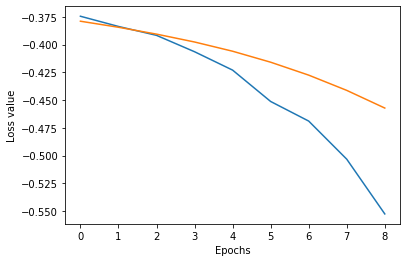

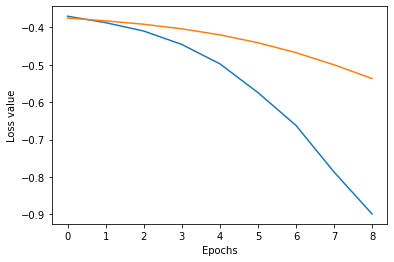

In [18]:
import torch
import torch.nn as nn
import gc
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import torch.nn.functional as F
import matplotlib.pyplot as plt

folds = 2
seed = 922

kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
test_preds = np.zeros((len(X_test), len(target_cols)))
fold_scores = []
j=0
enc_size = [[512, 256], [1024, 512]]
dec_size = [[256], [512]]
dropout = [0.25, 0.1]

for train_index, val_index in kf.split(X_train[:10]):
    x_train, y_train = X_train.iloc[train_index], Y_train.iloc[train_index]
    x_val, y_val = X_train.iloc[val_index], Y_train.iloc[val_index]
    
    X_transformed = csrToTensor(transformer.fit_transform(x_train))
    y_train = torch.from_numpy(y_train.values).to(device)
    x_val = csrToTensor(transformer.transform(x_val))
    y_val = torch.from_numpy(y_val.values).to(device)

    
    model = MyNNClassifier(X_transformed.shape[1], enc_size[j], dec_size[j], len(target_cols), 
                           activation='relu', dropout=dropout[j]).to(device)
    print(model)
    j += 1
    
    criterion = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters())
    
    train_losses = []
    val_losses = []
    for i in range(1, 10):
        train_loss = train(model, optimizer, criterion, X_transformed, y_train, i)
        val_loss = evaluate(model, x_val, y_val, i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    model_path = path + 'model_' + str(j)
    torch.save(model.state_dict(), model_path)
    
    plot_path = path + 'plot_loss_model_' + str(j) + '.png'
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss value')
    plt.plot(np.log(train_losses))
    plt.plot(np.log(val_losses))
    plt.savefig(plot_path)
        
    preds = model.forward(x_val).detach().numpy()
    overall_score = 0
    
    for col_index, col in enumerate(target_cols):
        overall_score += spearmanr(preds[:, col_index], y_val[:, col_index]).correlation/len(target_cols)
        
    fold_scores.append(overall_score)
    del X_transformed
    del x_train
    del y_train
    del x_val
    del y_val
    gc.collect()

print(fold_scores)

In [ ]:
## Save Model:
# model_path = '/Users/shikha/Documents/projects/kaggle/google_qa/'
# torch.save(model.state_dict(), model_path)

## Load model
# model = MyNNClassifier(X_transformed.shape[1], enc_size[j], dec_size[j], len(target_cols), activation='relu', dropout=dropout[j])
# model.load_state_dict(torch.load(model_path))
# model.eval()